In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [13]:
# Dictionary to store reduced model solutions in
X_CMC_dict ={}

Parameters

In [7]:
eps = 0.5
K = 18  
J = 20
F = 10
hx = -1
hy = 1
dt = 10**-3
T_end = 10**3

### Integrate full L96 model

Uniform random initialization of X and Y

In [8]:
np.random.seed(0)
X_0 = 1-2*np.random.rand(K)
Y_0 = 1-2*np.random.rand(K,J)

RHS of X equation

In [9]:
def f(X,Y):
    B = hx*np.mean(Y, axis=1)
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

RHS of Y equation

In [10]:
def g(X,Y):
    dY = np.roll(Y,-1)*(np.roll(Y, 1) - np.roll(Y, -2)) - Y + hy*np.tile(X.reshape((K,1)), (1,J))
    dY *= 1/eps
    return dY

Integrate with RK-2 method

In [11]:
def RK_2(X_0, Y_0, N):
    X = np.zeros((K, N))
    Y = np.zeros((K, J, N))
    
    X[:,0] = X_0
    Y[:,:,0] = Y_0

    for n in range(1,N):
        # # Runge-Kutta 2 integration
        k1_X = dt * f(X[:,n-1], Y[:,:,n-1])
        k1_Y = dt * g(X[:,n-1], Y[:,:,n-1])
        
        k2_X = dt * f(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        k2_Y = dt * g(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        
        X[:,n] = X[:,n-1] + 0.5 * (k1_X + k2_X)
        Y[:,:,n] = Y[:,:,n-1] + 0.5 * (k1_Y + k2_Y)
    
    return X, Y


In [12]:
t_array = np.arange(0, T_end+dt, dt)
X_full, Y_full = RK_2(X_0, Y_0, len(t_array))

Save the outcomes with time resolution $Dt$ separately

### Create reduced model

In [14]:
Dt = 10**-2
stepsize = int(Dt/dt)
X_full_coarse = X_full[:,::stepsize]
Y_full_coarse = Y_full[:,:,::stepsize]
B_full_coarse = hx*np.mean(Y_full_coarse, axis=1)

Create bins $I_{i}$ for $X_{k}$ 

In [15]:
N_bins_X = 16
X_bin_edges = np.linspace(-4.5, 9.5, N_bins_X-1)
X_bin_edges

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,
        6.5,  7.5,  8.5,  9.5])

Create bins $\mathcal{J}_{i,j,m}^{n}$ for $B_k$ and compute bin means

In [16]:
N_bins_B = 4
B_bins_edges = np.zeros((N_bins_X, N_bins_B-1))

X_coarse_flattened_bins = np.digitize(X_full_coarse.flatten(), X_bin_edges)

for n in range(N_bins_X):
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse.flatten()[X_bin_index]
    bins = np.quantile(B_coarse_flattened_bin, np.linspace(0, 1, N_bins_B + 1))
    B_bins_edges[n,:] = bins[1:-1]

# Use bin means of original model in case of empty bins
B_means = np.zeros((N_bins_X, N_bins_B))

for n in range(N_bins_X):
    B_n_bins_edges = B_bins_edges[n,:]
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse.flatten()[X_bin_index]
    B_k_bin_index = np.digitize(B_coarse_flattened_bin, B_n_bins_edges)
    for j in range(N_bins_B):
        B_k_bin_index_j = np.where(B_k_bin_index == j)
        B_means[n,j] = np.mean(B_coarse_flattened_bin[B_k_bin_index_j])

In [17]:
B_bins_edges_ngh = np.zeros((N_bins_X, N_bins_X, N_bins_X, N_bins_B-1))
B_means_ngh = np.zeros((N_bins_X, N_bins_X, N_bins_X, N_bins_B))

for n in range(N_bins_X):
    for m in range(N_bins_X):
        for l in range(N_bins_X):
            
            B_coarse_bin = np.array([])
            for k in range(K):
                X_k_coarse_bins = np.digitize(X_full_coarse[k,:], X_bin_edges)
                X_k_min_1_coarse_bins = np.digitize(np.roll(X_full_coarse, 1 ,axis=0)[k,:], X_bin_edges)
                X_k_plus_1_coars_bins = np.digitize(np.roll(X_full_coarse, -1 ,axis=0)[k,:], X_bin_edges)
                X_bin_index = np.where(
                    (X_k_coarse_bins == n) & 
                    (X_k_min_1_coarse_bins == m) & 
                    (X_k_plus_1_coars_bins == l)
                )
                B_coarse_bin = np.append(B_coarse_bin, B_full_coarse[k, X_bin_index])
              
            if len(B_coarse_bin) > 0:   
                bins = np.quantile(B_coarse_bin, np.linspace(0, 1, N_bins_B + 1))
                B_bins_edges_ngh[n,m,l,:] = bins[1:-1]
                B_k_bin_index = np.digitize(B_coarse_bin, B_bins_edges_ngh[n,m,l,:])
                for B_bin in range(N_bins_B):
                    if len(B_coarse_bin[B_k_bin_index == B_bin]) > 0:
                        B_means_ngh[n,m,l,B_bin] = np.mean(B_coarse_bin[B_k_bin_index == B_bin])
                    else:
                        # use bin means of original model in case of empty bins
                        B_means_ngh[n,m,l,B_bin] = B_means[n,B_bin]
            else:
                # use bin means of original model in case of empty bins
                B_means_ngh[n,m,l,:] = B_means[n,:]
                    

Calculate transition matrices

In [18]:
T = np.zeros((N_bins_X, N_bins_X, N_bins_X, N_bins_B, N_bins_X, N_bins_X, N_bins_X, N_bins_B))

for k in range(K):
    X_k_coarse_bins = np.digitize(X_full_coarse[k,:], X_bin_edges)
    X_k_min_1_coarse_bins = np.digitize(np.roll(X_full_coarse, 1 ,axis=0)[k,:], X_bin_edges)
    X_k_plus_1_coars_bins = np.digitize(np.roll(X_full_coarse, -1 ,axis=0)[k,:], X_bin_edges)
    for n in range(len(X_k_coarse_bins)-1):
        X_k_n_bin = X_k_coarse_bins[n]
        X_k_n_min_1_bin = X_k_min_1_coarse_bins[n] 
        X_k_n_plus_1_bin = X_k_plus_1_coars_bins[n]

        B_k_n = B_full_coarse[k, n]
        B_k_n_bin = np.digitize(
            B_k_n, 
            B_bins_edges_ngh[
                X_k_n_bin,
                X_k_n_min_1_bin,
                X_k_n_plus_1_bin,
                :
                ]
            )
        
        X_k_n_next_bin = X_k_coarse_bins[n+1]
        X_k_n_min_1_next_bin = X_k_min_1_coarse_bins[n+1] 
        X_k_n_plus_1_next_bin = X_k_plus_1_coars_bins[n+1]

        B_k_n_next = B_full_coarse[k, n+1]

        B_k_n_next_bin = np.digitize(
            B_k_n_next, 
            B_bins_edges_ngh[
                X_k_n_next_bin,
                X_k_n_min_1_next_bin,
                X_k_n_plus_1_next_bin,
                :
                ]
            )
        T[
            X_k_n_bin, 
            X_k_n_min_1_bin, 
            X_k_n_plus_1_bin, 
            B_k_n_bin, 
            X_k_n_next_bin, 
            X_k_n_min_1_next_bin, 
            X_k_n_plus_1_next_bin, 
            B_k_n_next_bin
        ] += 1

In [19]:
P = np.zeros((N_bins_X, N_bins_X, N_bins_X, N_bins_B, N_bins_X, N_bins_X, N_bins_X, N_bins_B))
for i_1 in range(N_bins_X):
    for i_2 in range(N_bins_X):
        for i_3 in range(N_bins_X):
            for n_1 in range(N_bins_B):
                for i_4 in range(N_bins_X):
                    for i_5 in range(N_bins_X):
                        for i_6 in range(N_bins_X): 
                                if np.sum(T[i_1,i_2,i_3,n_1,i_4,i_5,i_6,:]) != 0:
                                    for m in range(N_bins_B):
                                        P[i_1,i_2,i_3,n_1,i_4,i_5,i_6,m] = T[i_1,i_2,i_3,n_1,i_4,i_5,i_6,m]/np.sum(T[i_1,i_2,i_3,n_1,i_4,i_5,i_6,:])
                                else:
                                    P[i_1,i_2,i_3,n_1,i_4,i_5,i_6,n_1] = 1

Conditional Markov Chain integration

In [20]:
def G(X,B):
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

In [24]:
def CMC(X_0, B_0, N):
    X = np.zeros((K, N))
    B = np.zeros((K, N))
    
    X[:,0] = X_0
    B[:,0] = B_0

    no_data_count = 0
    
    for n in range(1,N):
        X_bin_current = np.digitize(X[:,n-1], X_bin_edges)
        X_min_1_bin_current = np.digitize(np.roll(X[:,n-1], 1), X_bin_edges)
        X_plus_1_bin_current = np.digitize(np.roll(X[:,n-1], -1), X_bin_edges)
        B_bin_current = [np.digitize(B[k,n-1], B_bins_edges_ngh[X_bin_current,X_min_1_bin_current, X_plus_1_bin_current,:][k,:]) for k in range(K)]

        # Runge-Kutta 2 integration
        k1 = Dt * G(X[:,n-1], B[:,n-1])
        k2 = Dt * G(X[:,n-1] + k1, B[:,n-1])
        X[:,n] = X[:,n-1] + 0.5*(k1+k2)

        X_bin_next = np.digitize(X[:,n], X_bin_edges)
        X_min_1_bin_next = np.digitize(np.roll(X[:,n], 1), X_bin_edges)
        X_plus_1_bin_next = np.digitize(np.roll(X[:,n], -1), X_bin_edges)

        B_bin_next = [
            np.random.choice(
                N_bins_B, 
                p=P[
                    X_bin_current,
                    X_min_1_bin_current,
                    X_plus_1_bin_current, 
                    B_bin_current, 
                    X_bin_next, 
                    X_min_1_bin_next,
                    X_plus_1_bin_next,
                    :
                ][k,:]
            ) 
            for k in range(K)
        ]
        if np.any(T[
                    X_bin_current,
                    X_min_1_bin_current,
                    X_plus_1_bin_current, 
                    B_bin_current, 
                    X_bin_next, 
                    X_min_1_bin_next,
                    X_plus_1_bin_next,
                    :
                ] == 0):
            no_data_count += sum(T[
                    X_bin_current,
                    X_min_1_bin_current,
                    X_plus_1_bin_current, 
                    B_bin_current, 
                    X_bin_next, 
                    X_min_1_bin_next,
                    X_plus_1_bin_next,
                    :
                ] == 0)
        B[:,n] = B_means_ngh[X_bin_next, X_min_1_bin_next, X_plus_1_bin_next, B_bin_next]
    return X, no_data_count

In [25]:
t_array_CMC = np.arange(0, T_end+Dt, Dt)
B_0 = hx*np.mean(Y_0, axis=1)
X_CMC_dict[N_bins_X], no_data_count = CMC(X_0, B_0, len(t_array_CMC))

In [27]:
np.mean(no_data_count)/(K*len(t_array_CMC))

0.5241379530649138

Plotting of pdf's

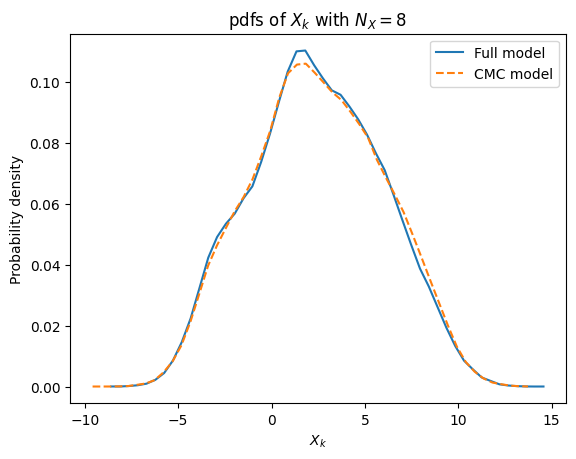

In [161]:
N_bins_X = 8
# Calculate the pdf
hist_full, bins_full = np.histogram(X_full.flatten(), bins=50, density=True)
bin_centers_full = (bins_full[:-1] + bins_full[1:]) / 2
pdf_full = hist_full 
plt.plot(bin_centers_full, pdf_full, label='Full model')

#Plot the pdf's
for n in [-2]:
    hist_CMC, bins_CMC = np.histogram(X_CMC_dict[N_bins_X].flatten(), bins=50, density=True)
    bin_centers_CMC = (bins_CMC[:-1] + bins_CMC[1:]) / 2
    pdf_CMC = hist_CMC 
    plt.plot(bin_centers_CMC, pdf_CMC, label=rf'CMC model', linestyle='dashed')

plt.xlabel('$X_{k}$')
plt.title(rf'pdfs of $X_k$ with $N_X={N_bins_X}$')
plt.ylabel('Probability density')
plt.legend()
plt.savefig(f"pdfs_neighbour_bins_{N_bins_X}.jpg", format="jpg", dpi=500)
plt.show()

Compute KS statistics

In [2]:
# for n in [-4, -6, -8, -10, -12]:
ks_stat, p_value = kstest(rvs=X_full.flatten(), cdf=X_CMC_dict[N_bins_X].flatten())
# Print the results
print(f"delta_t:",n)
print("KS statistic:", ks_stat)
print("p-value:", p_value)